In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
# from nltk.corpus import stopwords
import string
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import sys
import csv

In [23]:
# csv.field_size_limit(sys.maxsize)

# # Define chunk size and sampling ratio
# CHUNK_SIZE = 100000
# SAMPLE_RATIO = 0.10

# sampled_chunks = []

# for chunk in pd.read_csv("news_cleaned_2018_02_13.csv", usecols=["content", "type"], dtype=str, encoding="utf-8",
#                          on_bad_lines="skip", low_memory=True, chunksize=CHUNK_SIZE, engine="python"):
#     chunk_sample = chunk.sample(frac=SAMPLE_RATIO, random_state=42)  # Sample 10% of each chunk
#     sampled_chunks.append(chunk_sample)

# # Combine all sampled chunks
# df_sampled = pd.concat(sampled_chunks, ignore_index=True)

In [24]:
dataset = pd.read_csv('news_sampled_10percent.csv')

## Distribution of Labels

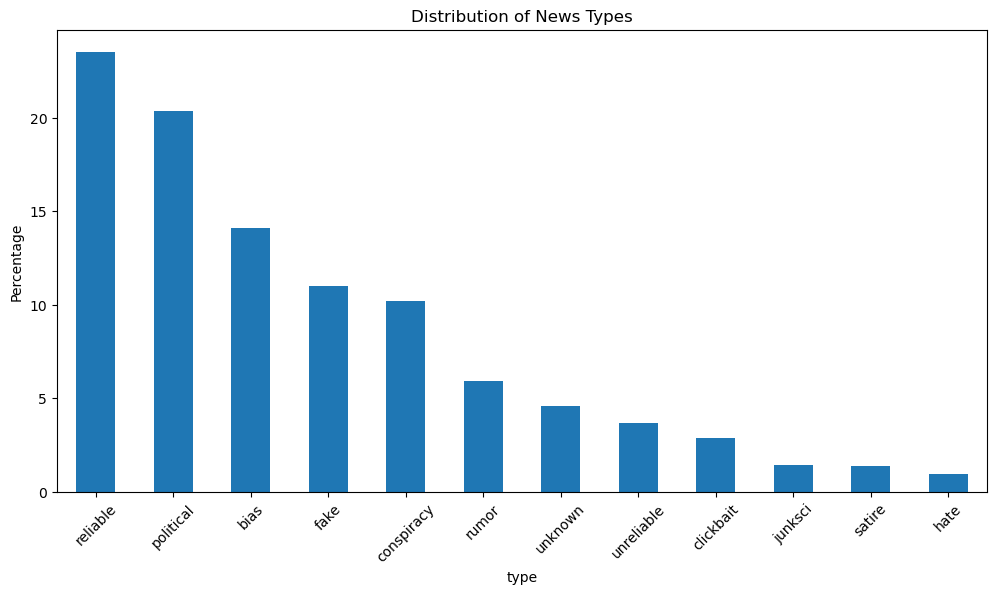

In [25]:
import matplotlib.pyplot as plt

class_dist = dataset['type'].value_counts(normalize=True) * 100

plt.figure(figsize=(12,6))
class_dist.plot(kind='bar')
plt.title('Distribution of News Types')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()

## Class Distribution

In [26]:
print(f"Initial shape: {dataset.shape}")
print(f"Missing values before cleaning:\n{dataset.isna().sum()}")

# Remove rows with missing values
dataset = dataset.dropna()
print(f"\nShape after removing NA values: {dataset.shape}")

# Basic statistics
print("\nClass distribution:")
print(dataset['type'].value_counts(normalize=True))

Initial shape: (852909, 2)
Missing values before cleaning:
type       40197
content       14
dtype: int64

Shape after removing NA values: (812711, 2)

Class distribution:
type
reliable      0.235268
political     0.203539
bias          0.140811
fake          0.110237
conspiracy    0.102222
rumor         0.058983
unknown       0.045626
unreliable    0.036944
clickbait     0.028572
junksci       0.014411
satire        0.013861
hate          0.009525
Name: proportion, dtype: float64


## URL Count Distribution by News Type

               count      mean       std  min  25%  50%  75%    max
type                                                               
bias        114439.0  0.198254  1.294395  0.0  0.0  0.0  0.0  200.0
clickbait    23221.0  0.550751  1.863973  0.0  0.0  0.0  0.0   49.0
conspiracy   83077.0  0.422873  2.013972  0.0  0.0  0.0  0.0  139.0
fake         89591.0  0.668069  2.119162  0.0  0.0  0.0  1.0  263.0
hate          7741.0  0.253197  1.782333  0.0  0.0  0.0  0.0  131.0
junksci      11712.0  0.456967  2.083032  0.0  0.0  0.0  0.0  110.0
political   165418.0  0.119878  1.151179  0.0  0.0  0.0  0.0  162.0
reliable    191205.0  0.023483  0.352175  0.0  0.0  0.0  0.0   49.0
rumor        47936.0  0.005153  0.122022  0.0  0.0  0.0  0.0    9.0
satire       11265.0  0.043142  0.264668  0.0  0.0  0.0  0.0    5.0
unknown      37081.0  0.299318  1.724693  0.0  0.0  0.0  0.0  146.0
unreliable   30025.0  0.063181  1.332773  0.0  0.0  0.0  0.0  195.0


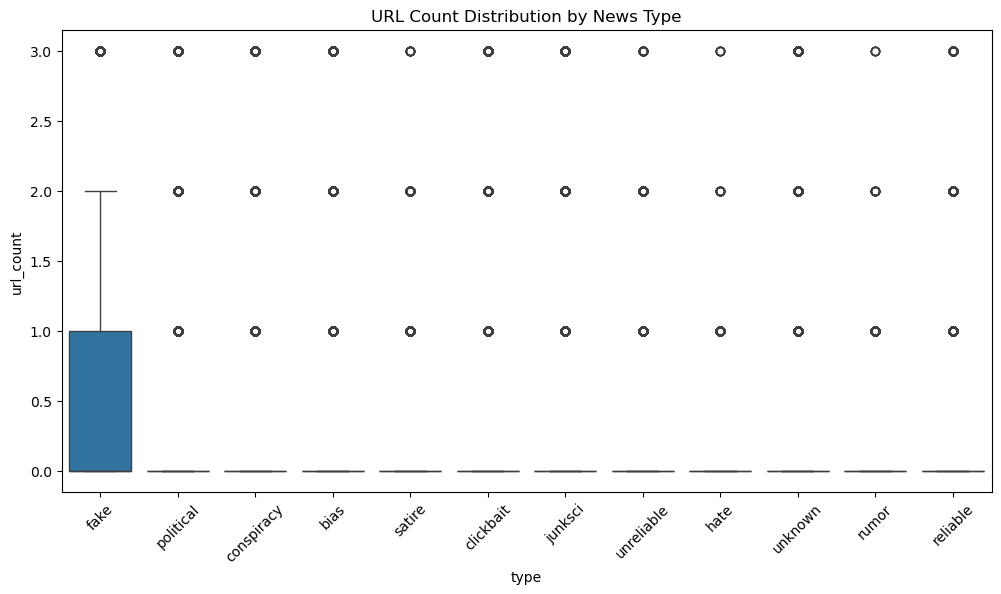

In [27]:
import seaborn as sns
import re

# Count URLs in content
dataset['url_count'] = dataset['content'].apply(lambda x: len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', str(x))))

# Compare URL counts by news type
url_stats = dataset.groupby('type')['url_count'].describe()
print(url_stats)

plt.figure(figsize=(12,6))
sns.boxplot(x='type', y='url_count', data=dataset[dataset['url_count'] < dataset['url_count'].quantile(0.99)])
plt.title('URL Count Distribution by News Type')
plt.xticks(rotation=45)
plt.show()

## Noun Density

               count      mean       std  min       25%       50%       75%  \
type                                                                          
bias        114439.0  0.186954  0.174167  0.0  0.107023  0.148014  0.212121   
clickbait    23221.0  0.194156  0.097873  0.0  0.132231  0.175403  0.232759   
conspiracy   83077.0  0.176362  0.144323  0.0  0.088235  0.144928  0.230769   
fake         89591.0  0.252841  0.204006  0.0  0.133946  0.186386  0.278481   
hate          7741.0  0.168220  0.076639  0.0  0.122257  0.154608  0.198630   
junksci      11712.0  0.127682  0.070469  0.0  0.088305  0.105536  0.150000   
political   165418.0  0.215770  0.128409  0.0  0.123393  0.173913  0.275862   
reliable    191205.0  0.202589  0.092693  0.0  0.143885  0.178038  0.232026   
rumor        47936.0  0.198713  0.118367  0.0  0.130268  0.172264  0.224926   
satire       11265.0  0.195623  0.174873  0.0  0.105919  0.148148  0.211268   
unknown      37081.0  0.181481  0.095721  0.0  0.116

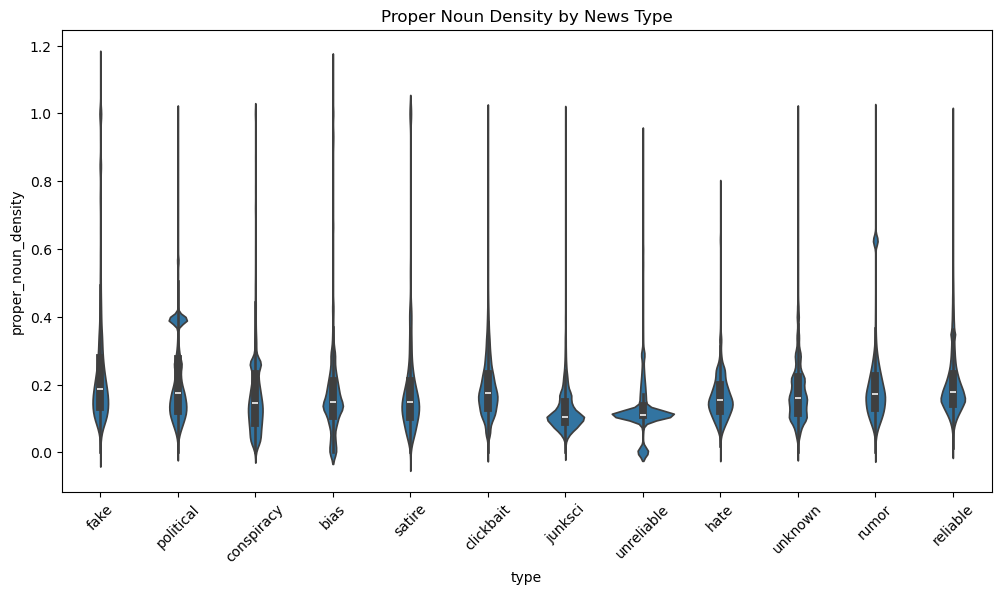

In [28]:
# Count proper nouns (approximated by capitalized words)
dataset['proper_noun_count'] = dataset['content'].apply(lambda x: len(re.findall(r'\b[A-Z][a-z]+\b', str(x))))

# Normalize by content length
dataset['proper_noun_density'] = dataset['proper_noun_count'] / dataset['content'].str.split().str.len()

# Compare by type
pn_stats = dataset.groupby('type')['proper_noun_density'].describe()
print(pn_stats)

plt.figure(figsize=(12,6))
sns.violinplot(x='type', y='proper_noun_density', data=dataset)
plt.title('Proper Noun Density by News Type')
plt.xticks(rotation=45)
plt.show()

### Cleaning data

In [29]:
df = dataset.dropna(subset=["type", "content"])

# Print unique values in the 'type' column
print(df['type'].unique())

['fake' 'political' 'conspiracy' 'bias' 'satire' 'clickbait' 'junksci'
 'unreliable' 'hate' 'unknown' 'rumor' 'reliable']


### Creating binary Label Column

In [31]:
real_labels = ['reliable', 'political', 'unbiased']
fake_labels = ['fake', 'bias', 'rumor', 'hate', 'unreliable', 'clickbait', 'conspiracy', 'satire', 'junksci']

df = dataset[dataset['type'].isin(real_labels + fake_labels)]  # Filter only the relevant types

# Create a binary label column
dataset['label'] = dataset['type'].apply(lambda x: 1 if x in fake_labels else 0)

In [32]:
print(df['label'].value_counts())

label
1    419007
0    356623
Name: count, dtype: int64


### Splittin Data

In [33]:
train_data, temp_data = train_test_split(dataset, test_size=0.2, random_state=42)

# # Second split: split the 20% into equal parts (10% validation, 10% test)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# # Verify the sizes
print(f"Training set size: {len(train_data)} ({len(train_data)/len(dataset)*100:.1f}%)")
print(f"Validation set size: {len(val_data)} ({len(val_data)/len(dataset)*100:.1f}%)")
print(f"Test set size: {len(test_data)} ({len(test_data)/len(dataset)*100:.1f}%)")
print(dataset['label'].value_counts())
# X = dataset['content']
# y = dataset['label']

# # 80% train, 10% val, 10% test
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

Training set size: 650168 (80.0%)
Validation set size: 81271 (10.0%)
Test set size: 81272 (10.0%)
label
1    419007
0    393704
Name: count, dtype: int64


## Training Binary Classifier

In [34]:
model = MultinomialNB()
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2, 2))

In [39]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()


def preprocess_text(text):
	if not isinstance(text, str):
			return ""

	text = text.lower()
	text = re.sub(r'\d+', '', text)
	text = re.sub(r'[^\x00-\x7F]+', ' ', text)
	text = re.sub(r'\s+', ' ', text).strip()
	text = text.translate(str.maketrans('', '', string.punctuation))
	words = text.split()
	filtered_words = [word for word in words if word not in stop_words]
	lemmatized_words = [wnl.lemmatize(word, pos="v") for word in filtered_words]
	return " ".join(lemmatized_words)

[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/apple/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
x_train_proceesed = train_data['content'].apply(preprocess_text)
print("Cleaning")
x_test_proceesed = test_data['content'].apply(preprocess_text)

Cleaning


In [42]:
import joblib

model = joblib.load('fake_news_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# x_train_vector = vectorizer.fit_transform(x_train_proceesed)
x_test_vector = vectorizer.transform(x_test_proceesed)

# model.fit(x_train_vector, train_data['label'])

pred = model.predict(x_test_vector)

print("Accuracy",accuracy_score(test_data['label'], pred))
print("Classification Report",classification_report(test_data['label'], pred))

Accuracy 0.9104857761590708
Classification Report               precision    recall  f1-score   support

           0       0.95      0.86      0.90     39380
           1       0.88      0.96      0.92     41892

    accuracy                           0.91     81272
   macro avg       0.91      0.91      0.91     81272
weighted avg       0.91      0.91      0.91     81272

